<a href="https://colab.research.google.com/github/mastersigat/Script_Python_M2SIGAT/blob/main/AirBnb_madrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛌 Diagnostic reproductible du marché de la location en AirBnb  🏩

Clémence François, Julie Poitevin, Léa Rouxel

Ce script permet de préparer puis d'analyser les données AirBnb dans n'importe quel ville.
Il est uniquement nécessaire de modifier les liens de téléchargement récupérables sur le site : [*Inside AirBnB*](http://insideairbnb.com/get-the-data.html)

Master SIGAT 2022

## 1- Initialisation de l'environnement de travail

### Installation des librairies Python nécessaires

In [ ]:
#Initialisation de l'environnement avec geopandas
!apt update
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!git clone https://github.com/geopandas/geopandas.git
!pip install geopandas
# Instal contextily (fonds de carte)
!pip install contextily
# Install mapclassify (cartographie thématique)
!pip install mapclassify
#Depuis sa version 0.8, Geopandas peut fonctionner de manière expérimental avec Pygeos ce qui accèlère certaines opérations
!pip install pygeos
# Pour la cartographie interactive
!pip install folium
# Pour l'affichage d'une échelle cartographique
!pip install matplotlib_scalebar
# Install H3Index (UBER)
!pip install h3

### Importation des librairies Python

In [ ]:
import pandas as pd #Gestion de données
import matplotlib as plt #Visualisation de données
import matplotlib.pyplot as mplt #Visualisation de données 2
import geopandas as gpd #Gestion données spatiales
import pygeos #Opérations sur les géométrie de données spatiales
import contextily as ctx #Fonds de carte
import numpy as np #Manipulation de tableaux
import shapely #Manipulation de géométrie
import shapely.geometry
from shapely.geometry import LineString, Point, Polygon
import folium #Cartographie interactive
import mapclassify #Cartographie thématique
from matplotlib_scalebar.scalebar import ScaleBar #Echelle cartographique
from h3 import h3

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## 2- Téléchargement et importation des différents jeux de données utilisés

### Données de proposition de location (Données : listing.csv)

In [ ]:
# Téléchargement
!wget -O Ville.csv http://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2021-12-08/visualisations/listings.csv

--2022-04-25 07:56:48--  http://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2021-12-08/visualisations/listings.csv
Resolving data.insideairbnb.com (data.insideairbnb.com)... 52.216.93.2
Connecting to data.insideairbnb.com (data.insideairbnb.com)|52.216.93.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2664648 (2.5M) [application/csv]
Saving to: ‘Ville.csv’

Ville.csv           100%[===================>]   2.54M  --.-KB/s    in 0.1s    

2022-04-25 07:56:49 (17.0 MB/s) - ‘Ville.csv’ saved [2664648/2664648]



In [ ]:
#Importer le CSV des locations en un dataframe (séparateur ,)

Ville = pd.read_csv("Ville.csv", sep=',')

### Données des emprises de quartiers correspondant (Données : neighbourhoods.geojson)



In [ ]:
# Téléchargement
!wget -O neighbourhoods.geojson http://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2021-12-08/visualisations/neighbourhoods.geojson

--2022-04-25 07:56:52--  http://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2021-12-08/visualisations/neighbourhoods.geojson
Resolving data.insideairbnb.com (data.insideairbnb.com)... 52.216.93.2
Connecting to data.insideairbnb.com (data.insideairbnb.com)|52.216.93.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383969 (375K) [application/octet-stream]
Saving to: ‘neighbourhoods.geojson’

neighbourhoods.geoj 100%[===================>] 374.97K  --.-KB/s    in 0.08s   

2022-04-25 07:56:52 (4.83 MB/s) - ‘neighbourhoods.geojson’ saved [383969/383969]



In [ ]:
#Importer la couche des quartiers

Quartiers= gpd.read_file("neighbourhoods.geojson", encoding='utf-8')

## 3- Préparation des données

In [ ]:
# Affichage des premières lignes du dataframe Ville

# Ville.head()

In [ ]:
# Vérification du nombre de lignes et de colonnes dans le dataframe Ville

# Ville.shape

In [ ]:
#Transformation du Dataframe Ville en un GeoDataframe

VilleGeom = gpd.GeoDataFrame(Ville, crs = 'epsg:4326', geometry=gpd.points_from_xy(Ville.longitude, Ville.latitude))
# VilleGeom.crs

### Affichage d'une première analyse catégorisant les biens à la location AirBnb en fonction de leur type

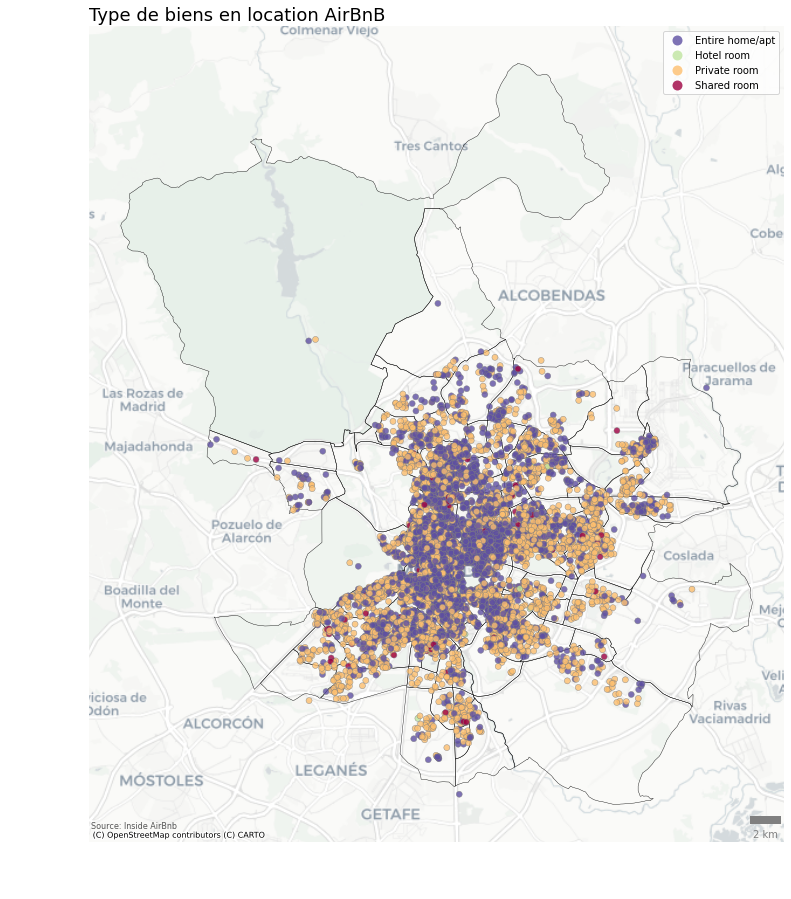

In [ ]:
#Carte des biens en fonction de leur type 

Carte1, ax = plt.pyplot.subplots(figsize=(15,15)) # Définition de l'interface d'accueil de la carte

Quartiers.boundary.to_crs('EPSG:3857').plot(ax=ax, linewidth=0.4, color = 'black') # Affichage des contours des quartiers
#Affichage des biens catégorisés
VilleGeom.to_crs('EPSG:3857').plot(ax=ax, zorder=3, column = "room_type", linewidth=0.5, cmap='Spectral_r', alpha= 0.8, edgecolor='grey', legend=True)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron) # Affichage d'un fond de carte

ax.axis("off") # Suppression de l'affichage des objets axes

# Création d'un objet annotation pour ajouter une source à la carte
ax.annotate('Source: Inside AirBnb',xy=(0.115, 0.087), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=8, color='#555555')

plt.pyplot.title('Type de biens en location AirBnB', loc='left', fontsize=18) # Affichage d'un titre

# Ajout d'une échelle cartographique
ax.add_artist(ScaleBar(1, length_fraction=0.1, location = "lower right", box_alpha=0, color="grey"))

#plt.pyplot.show() # Affichage de la carte finale

Text(0.5, 1.0, 'Nombre de biens en location AirBnb en fonction de leur type')

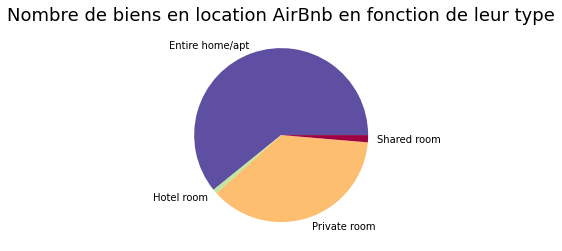

In [ ]:
# Préparation d'un dataframe qui regrouper les locations par catégorie de biens (GROUP BY)

Categorie = Ville[["room_type", "id"]].groupby("room_type").count() # Mise en place du nouveau dataframe
Categorie = Categorie.sort_values("room_type", ascending=True) # Réorganisation du dataframe trié par ordre alphabétique

# Affichage d'un diagramme circulaire du nombre de biens par type

Categorie.plot.pie(y="id", ylabel="", legend=False, cmap='Spectral_r') # Construction du diagramme
plt.pyplot.title("Nombre de biens en location AirBnb en fonction de leur type", fontsize=18) # Ajout d'un titre au diagramme
# Categorie.head() # Affichage au besoin du tableau correspondant

### Mise en place de graphiques de pré-analyse des locations en AirBnb

#### Fréquence des prix (par nuitée) des biens à la location en AirBnb

Text(0.5, 0, 'Prix par nuitée')

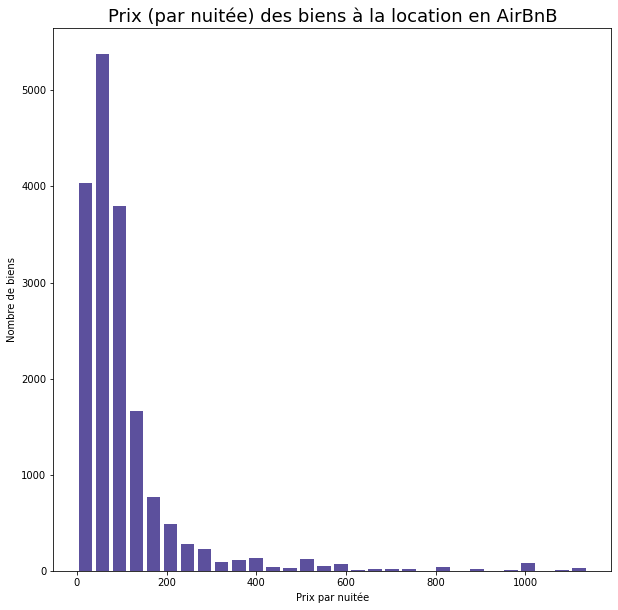

In [ ]:
# Suppression des valeurs aberrantes en ôtant le dernier centile
Villeprice = Ville[(Ville["price"] <= Ville.quantile(q=0.99)["price"])]

# Construction de l'histogramme des locations par prix
Villeprice.plot.hist(y='price', figsize=(10, 10), bins= 30, color = '#5C509D', rwidth=0.8, legend=False)

# Ajout d'un titre et d'un label à chaque axe
plt.pyplot.title("Prix (par nuitée) des biens à la location en AirBnB", fontsize=18)
plt.pyplot.ylabel("Nombre de biens")
plt.pyplot.xlabel("Prix par nuitée")

#### Moyenne des prix (par nuitée) par type de biens

Text(0.5, 0, 'Type de biens')

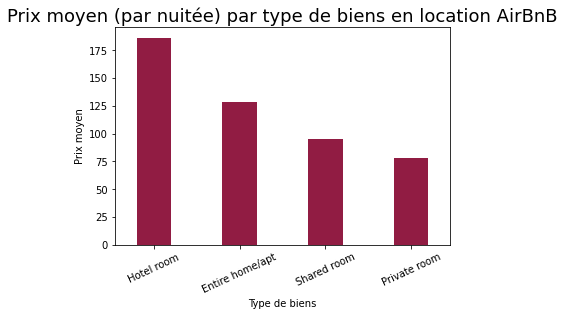

In [ ]:
# Préparation d'un dataframe qui moyenne les prix des biens par leur type (GROUP BY)
Moyprice = Villeprice[["room_type", "price"]].groupby("room_type").mean()
Moyprice = Moyprice.sort_values("price", ascending=False) # Réorganisation du dataframe par prix décroissant

# Affichage d'un graphique en bar de la moyenne des prix par type
Moyprice.plot(kind='bar', legend=False, color='#911C43', rot=25, width=0.4)

# Ajout d'un titre et d'un label pour chaque axe
plt.pyplot.title("Prix moyen (par nuitée) par type de biens en location AirBnB", fontsize=18)
plt.pyplot.ylabel("Prix moyen")
plt.pyplot.xlabel("Type de biens")

# Moyprice.head() # Affichage au besoin du tableau correspondant

## 4- Analyse des besoins en location agrégés dans un carroyage de 100 carreaux

In [ ]:
# Transformation du dataframe des prix propres en geodataframe

VillepriceGeom = gpd.GeoDataFrame(Villeprice, crs = 'epsg:4326', geometry=gpd.points_from_xy(Villeprice.longitude, Villeprice.latitude))

In [ ]:
# Définir l'emprise de la grille
xmin, ymin, xmax, ymax= VillepriceGeom.total_bounds

# Paramétrer le nombre de cellules
n_cells=10
cell_size = (xmax-xmin)/n_cells

# Création des cellules
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1)  )
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs='EPSG:4326').reset_index()


# Cartographie pour contrôler
# ax = VillepriceGeom.plot(markersize=1, figsize=(12, 8))
# plt.pyplot.autoscale(False)
# cell.plot(ax=ax, facecolor="none", edgecolor='grey')
# ax.axis("off")

In [ ]:
#Jointure spatiale VillepriceGeom<>Grille

Etape1 = gpd.sjoin(VillepriceGeom, cell, how='left', op='within')
# Etape1.head(3)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if self.run_code(code, result):


#### Agrégation des données par nombre de biens par carreaux

In [ ]:
# Préparation d'un dataframe qui compte le nombre de biens (id) dans les carreaux (index_right) (GROUP BY)

Etape2 = Etape1[["index_right", "id"]].groupby("index_right").count()
Etape2 = Etape2.sort_values("id", ascending=False) 
# Etape2.head()

In [ ]:
# Faire la jointure attributaire

Etape3 = Etape2.merge(cell, left_on='index_right', right_on='index')
Etape3.rename(columns={'id': 'Nb'}, inplace=True)
Etape3 = gpd.GeoDataFrame(Etape3, geometry='geometry')
# Etape3.head()

Text(0.5, 0, 'Nombre de biens')

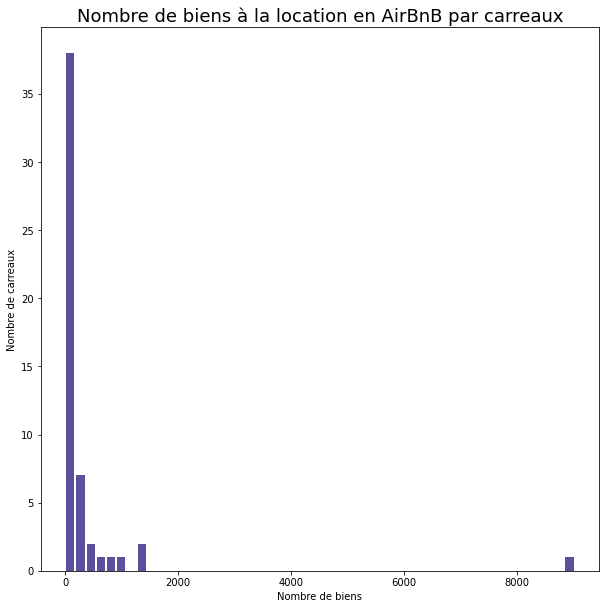

In [ ]:
# Création d'un histogramme relatif au nombre de biens à la location AirBnB par carreaux
Etape3["Nb"].plot.hist(bins=50, figsize=(10, 10), color = '#5C509D', rwidth=0.8, legend=False)

# Ajout d'un titre et d'un label à chaque axe
plt.pyplot.title("Nombre de biens à la location en AirBnB par carreaux", fontsize=18)
plt.pyplot.ylabel("Nombre de carreaux")
plt.pyplot.xlabel("Nombre de biens")

In [ ]:
#Verification somme

total1 = VillepriceGeom['id'].count()
total2 = Etape3['Nb'].sum()

# print(total1)
# print(total2)

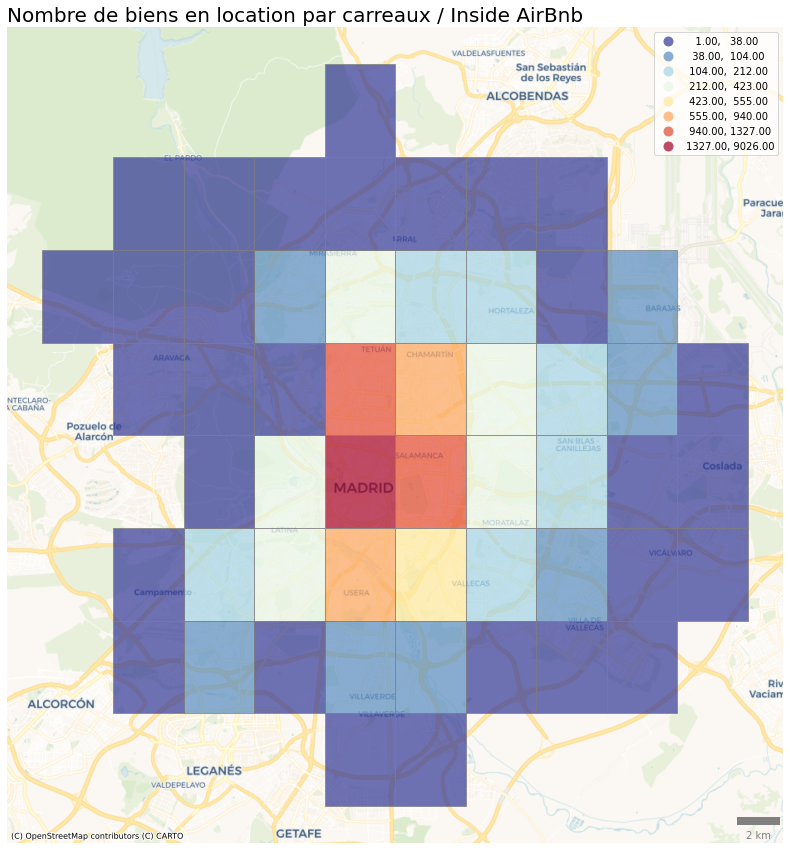

In [ ]:
#Cartographie du carroyage

Carte2, ax = plt.pyplot.subplots(figsize=(15,15))

# Affichage du carroyage catégorisé selon la méthode Fisher-Jenks sur le nombre de biens par carreaux
Etape3.to_crs('EPSG:3857').plot(ax=ax, column='Nb', figsize=(12, 8), k=8, cmap='RdYlBu_r', scheme='FisherJenks', edgecolor="grey", alpha=0.7, legend = 'true')
#Quartiers.boundary.to_crs('EPSG:3857').plot(ax=ax, linewidth=0.2, color = 'black') # Affichage des contours des quartiers

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager) # Affichage d'un fond de carte

ax.axis("off") # Suppression de l'affichage des objets axes

plt.pyplot.title("Nombre de biens en location par carreaux / Inside AirBnb", loc='left', fontsize=20) # Affichage d'un titre

# Ajout d'une échelle cartographique
ax.add_artist(ScaleBar(1, length_fraction=0.1, location = "lower right", box_alpha=0, color="grey"))

#plt.pyplot.show() # Affichage de la carte finale

#### Agrégation des données par prix moyens par carreaux

In [ ]:
# Préparation d'un dataframe qui calcul la moyenne du prix moyen des biens (price) dans les carreaux (index_right) (GROUP BY)

Etape4 = Etape1.dissolve(by="index_right", aggfunc="mean")
# Etape4.head(3)

In [ ]:
# Jointure attributaire permettant de rappatrier l'information du prix moyyen dans la géométrie des carreaux

cell.loc[Etape4.index, 'price']=Etape4.price.values
del Etape4
# cell.head()

Text(0.5, 0, 'Prix moyen par nuitée')

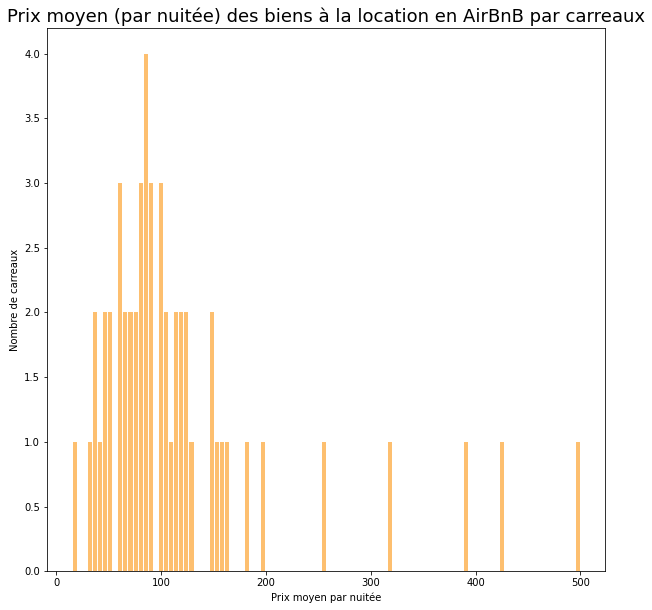

In [ ]:
# Création d'un histogramme relatif au prix moyens des biens à la location AirBnB par carreaux
cell["price"].plot.hist(bins=100, figsize=(10, 10), color = '#FDBF6F', rwidth=0.8, legend=False)

# Ajout d'un titre et d'un label à chaque axe
plt.pyplot.title("Prix moyen (par nuitée) des biens à la location en AirBnB par carreaux", fontsize=18)
plt.pyplot.ylabel("Nombre de carreaux")
plt.pyplot.xlabel("Prix moyen par nuitée")

In [ ]:
#Verification de la moyenne

total3 = VillepriceGeom['price'].mean()
total4 = cell['price'].mean()

# print(total3)
# print(total4)

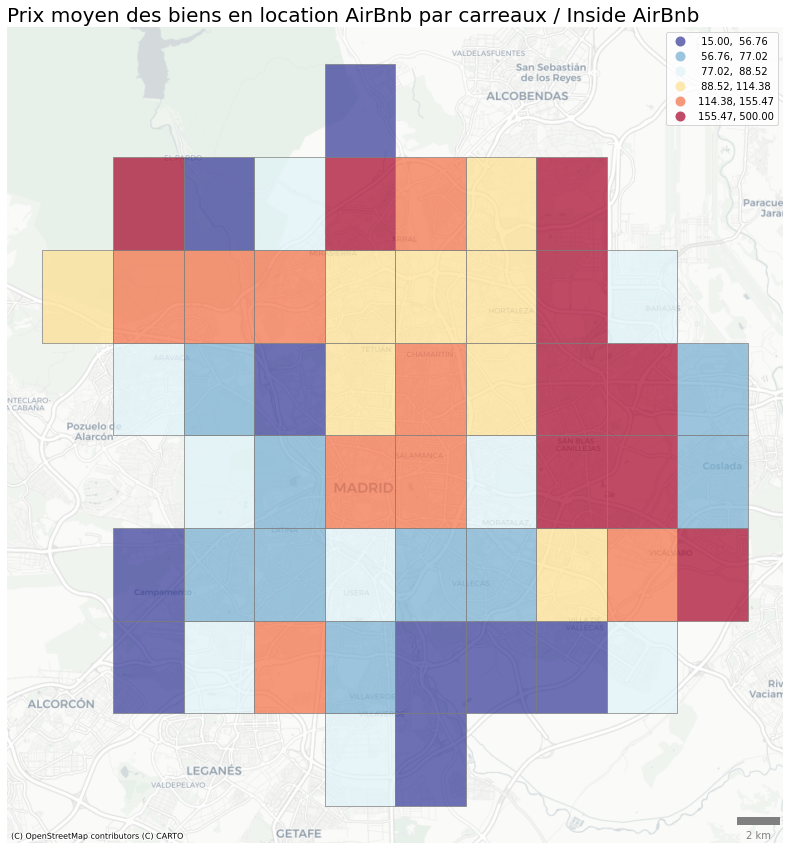

In [ ]:
#Cartographie du carroyage

Carte3, ax = plt.pyplot.subplots(figsize=(15,15)) # Définition de l'interface d'accueil de la carte

# Catégorisation des carreaux selon la méthode des quantiles sur le prix moyen par carreaux
cell.to_crs('EPSG:3857').plot(ax=ax, column='price', figsize=(12, 8), k=6, cmap='RdYlBu_r', scheme='quantiles', edgecolor="grey", alpha=0.7, legend = 'true')
#Quartiers.boundary.to_crs('EPSG:3857').plot(ax=ax, linewidth=0.2, color = 'black') # Affichage des contours des quartiers

ax.axis("off") # Suppression de l'affichage des objets axes

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron) # Affichage d'un fond de carte

plt.pyplot.title("Prix moyen des biens en location AirBnb par carreaux / Inside AirBnb", loc='left', fontsize=20) # Affichage d'un titre

# Ajout d'une échelle cartographique
ax.add_artist(ScaleBar(1, length_fraction=0.1, location = "lower right", box_alpha=0, color="grey"))

# plt.pyplot.show() # Affichage de la carte finale

## 5- Analyse des besoins en location agrégés dans un maillage hexagonal de 0,1km² par cellule

In [ ]:
#Création d'un maillage hexagonal (selon la résolution H3 de Uber)

h3_level = 9 # soit 0,1 km²
 
def lat_lng_to_h3(row):
    return h3.geo_to_h3(
      row.geometry.y, row.geometry.x, h3_level)
 
VillepriceGeom['h3'] = VillepriceGeom.apply(lat_lng_to_h3, axis=1)

### Agrégation des données par nombre de biens par mailles hexagonales

In [ ]:
# Préparation d'un dataframe qui calcule le nombre de biens dans les hexagones (GROUP BY)

Etape5 = VillepriceGeom.groupby(['h3']).h3.agg('count').to_frame('count').reset_index()
# Etape5.head()

Text(0.5, 0, 'Nombre de biens')

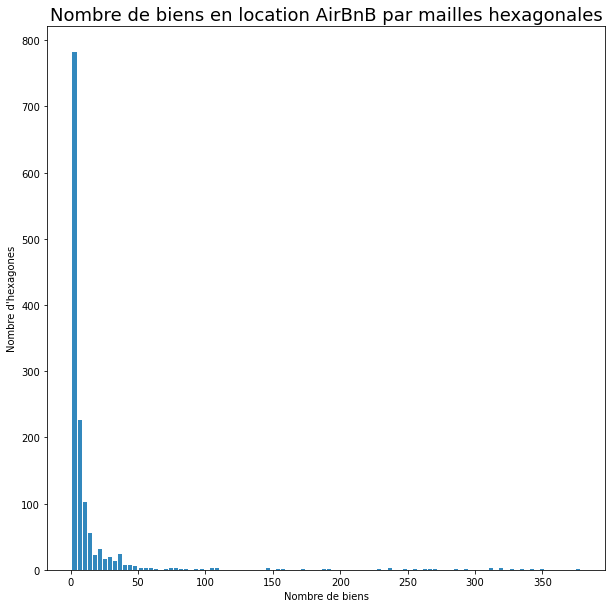

In [ ]:
# Création d'un histogramme relatif au nombre de biens à la location AirBnB par hexagone
Etape5.plot.hist(bins=100, figsize=(10, 10), color = '#3288bd', rwidth=0.8, legend=False)

# Ajout d'un titre et d'un label à chaque axe
plt.pyplot.title("Nombre de biens en location AirBnB par mailles hexagonales", fontsize=18)
plt.pyplot.ylabel("Nombre d'hexagones")
plt.pyplot.xlabel("Nombre de biens")

In [ ]:
#Verification somme

total5 = VillepriceGeom['id'].size
total6 = Etape5['count'].sum()

# print(total5)
# print(total6)

In [ ]:
# Création de la géométrie pour le maillage hexagonal

def add_geometry(row):
    points = h3.h3_to_geo_boundary(
      row['h3'], True)
    return Polygon(points)
 
Etape5['geometry'] = Etape5.apply(add_geometry, axis=1)
Etape6 = gpd.GeoDataFrame(Etape5, crs='EPSG:4326')
# Etape6.plot()
# Etape6.head()

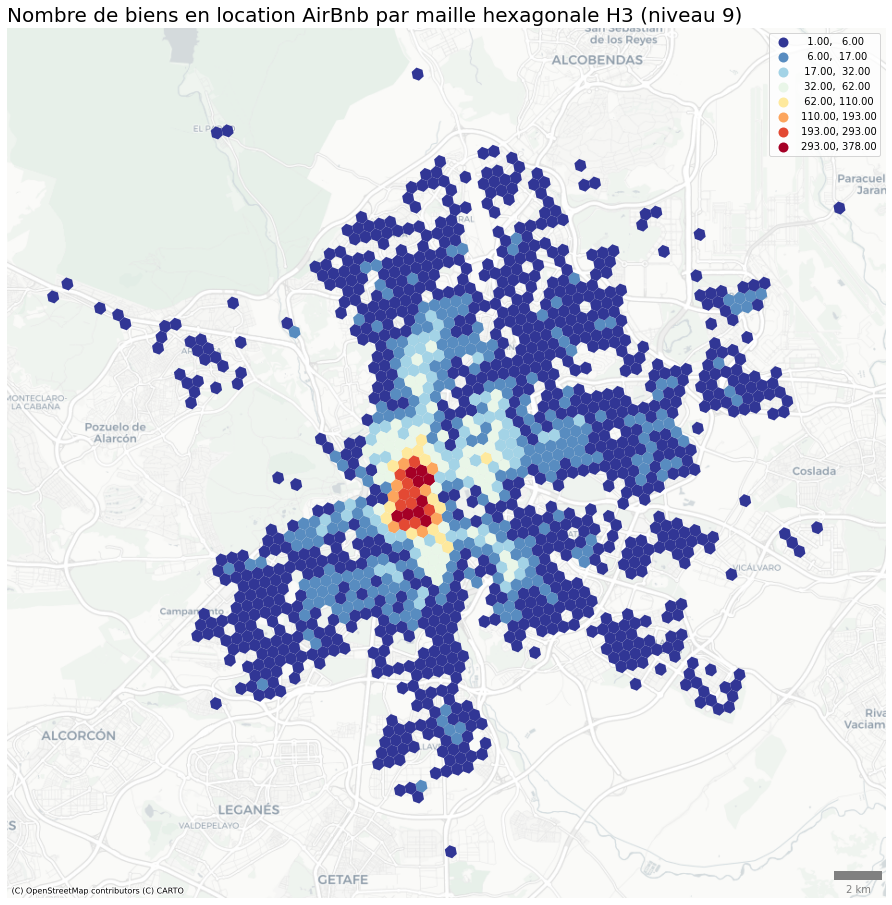

In [ ]:
# Cartographie du nombre de biens par hexagones

Carte4, ax = plt.pyplot.subplots(figsize=(18,16)) # Féinition de l'interface d'accueil de la carte

# Catégorisation des hexagones en fonction du nombre de biens selon la méthode de Fisher-Jenks
Etape6.to_crs('EPSG:3857').plot(ax=ax, column='count', figsize=(15, 10),k=8, cmap='RdYlBu_r', scheme='FisherJenks', legend=True)
#Quartiers.boundary.to_crs('EPSG:3857').plot(ax=ax, linewidth=0.2, color = 'black') # Affichage des contours des quartiers

ax.axis("off") # Suppression de l'affichage des objets axes

ctx.add_basemap(ax,  source=ctx.providers.CartoDB.Positron) # Affichage d'un fond de carte

plt.pyplot.title("Nombre de biens en location AirBnb par maille hexagonale H3 (niveau 9)", loc='left', fontsize=20) # Affichage d'un titre

# Ajout d'une échelle cartographique
ax.add_artist(ScaleBar(1, length_fraction=0.1, location = "lower right", box_alpha=0, color="grey"))

# plt.pyplot.show() # Affichage de la carte finale

### Agrégation des données par prix moyen par mailles hexagonales

In [ ]:
# Préparation d'un dataframe qui calcule la moyenne du prix moyen des biens (price) dans les hexagones (GROUP BY)

Etape7 = VillepriceGeom.groupby(['h3'])['price'].mean().to_frame('mean').reset_index()
# Etape7.head()

Text(0.5, 0, 'Prix moyen')

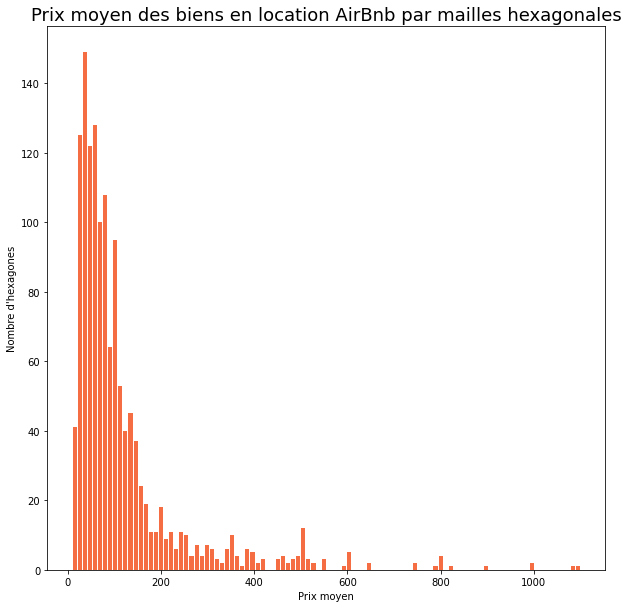

In [ ]:
#Création d'un histogramme relatif au nombre de biens à la location AirBnB par hexagone
Etape7.plot.hist(bins=100, figsize=(10, 10), color = '#f46d43', rwidth=0.8, legend=False)

# Ajout d'un titre et d'un label à chaque axe
plt.pyplot.title("Prix moyen des biens en location AirBnb par mailles hexagonales", fontsize=18)
plt.pyplot.ylabel("Nombre d'hexagones")
plt.pyplot.xlabel("Prix moyen")


In [ ]:
#Verification somme

total7 = VillepriceGeom['price'].mean()
total8 = Etape7['mean'].mean()

# print(total7)
# print(total8)

In [ ]:
# Ajout de la géométrie du maillage hexagonal
 
Etape7['geometry'] = Etape7.apply(add_geometry, axis=1)
Etape8 = gpd.GeoDataFrame(Etape7, crs='EPSG:4326')
# Etape8.plot()
# Etape8.head()

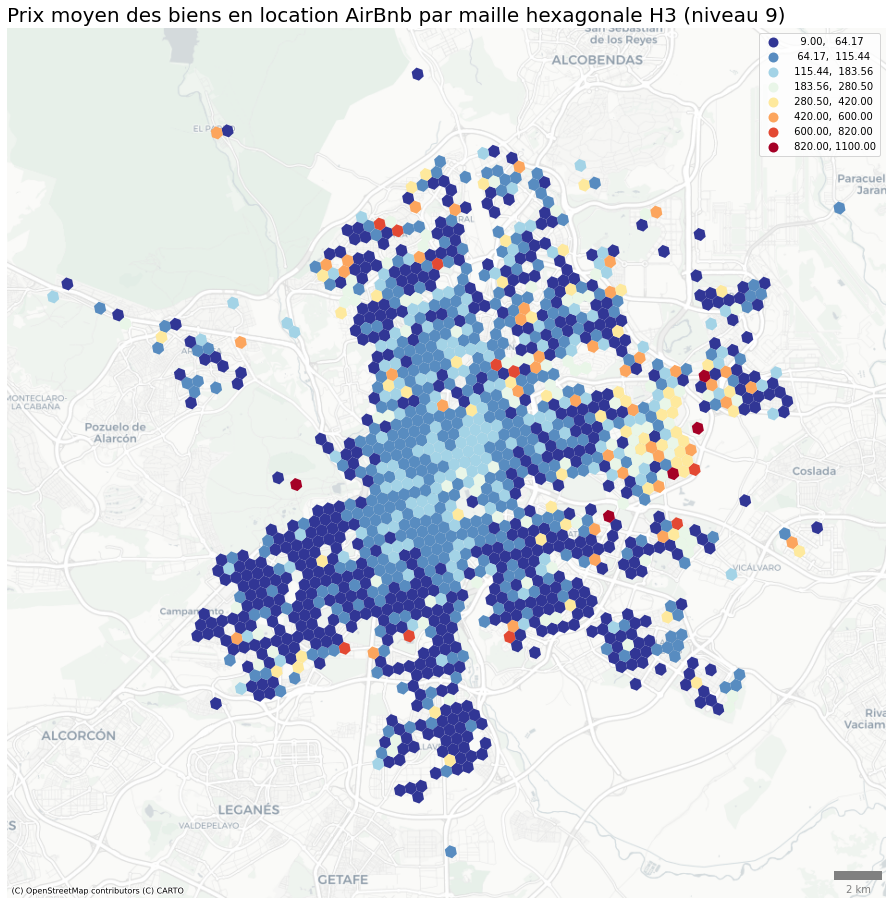

In [ ]:
# Cartographie du prix moyen des biens par hexagones

Carte5, ax = plt.pyplot.subplots(figsize=(18,16)) # Définition de l'interface d'accueil de la carte

# Catégorisation des hexagones en fonction de la moyenne des prix moyens des biens selon la méthode de Fisher-Jenks
Etape8.to_crs('EPSG:3857').plot(ax=ax, column='mean', figsize=(15, 10),k=8, cmap='RdYlBu_r', scheme='FisherJenks', legend=True)
#Quartiers.boundary.to_crs('EPSG:3857').plot(ax=ax, linewidth=0.2, color = 'black') # Affichage des contours des quartiers

ax.axis("off") # Suppression de l'affichage des objets axes

ctx.add_basemap(ax,  source=ctx.providers.CartoDB.Positron) # Affichage d'un fond de carte

plt.pyplot.title("Prix moyen des biens en location AirBnb par maille hexagonale H3 (niveau 9)", loc='left', fontsize=20) # Affichage d'un titre

# Ajout d'une échelle cartographique
ax.add_artist(ScaleBar(1, length_fraction=0.1, location = "lower right", box_alpha=0, color="grey"))

# plt.pyplot.show() # Affichage de la carte finale

## 6- Analyse complémentaire des données AirBnb

### Recherche du type de biens en location majoritaire dans chaque maille hexagonale

In [ ]:
# Préparation d'un dataframe qui compte le nombre de biens (id) par type dans les hexagones (GROUP BY)

Etape9 = VillepriceGeom.groupby(['h3','room_type'])['id'].count().to_frame('count').reset_index()
# Etape9.head()

In [ ]:
# Passage d'un dataframe en long à un data frame en large
Etape9 = pd.pivot_table(Etape9, values="count", index=["h3"], columns="room_type")

# Recherche de la valeur de compte la plus importante et renvoie du type de biens
Etape10 = Etape9.idxmax(axis = 1)

# Transformation du tableau en un dataframe contenant l'id du carreau et le type de bien le plus présent
Etape10 = Etape10.to_frame().reset_index()

# Renommage de la colonne Type
Etape10.rename(columns={0: 'Type'}, inplace=True)

# Affichage des premières lignes du tableau
# Etape10.head()

In [ ]:
# Ajout de la géométrie du maillage hexagonal
 
Etape10['geometry'] = Etape10.apply(add_geometry, axis=1)
Etape10 = gpd.GeoDataFrame(Etape10, crs='EPSG:4326')
# Etape10.plot()

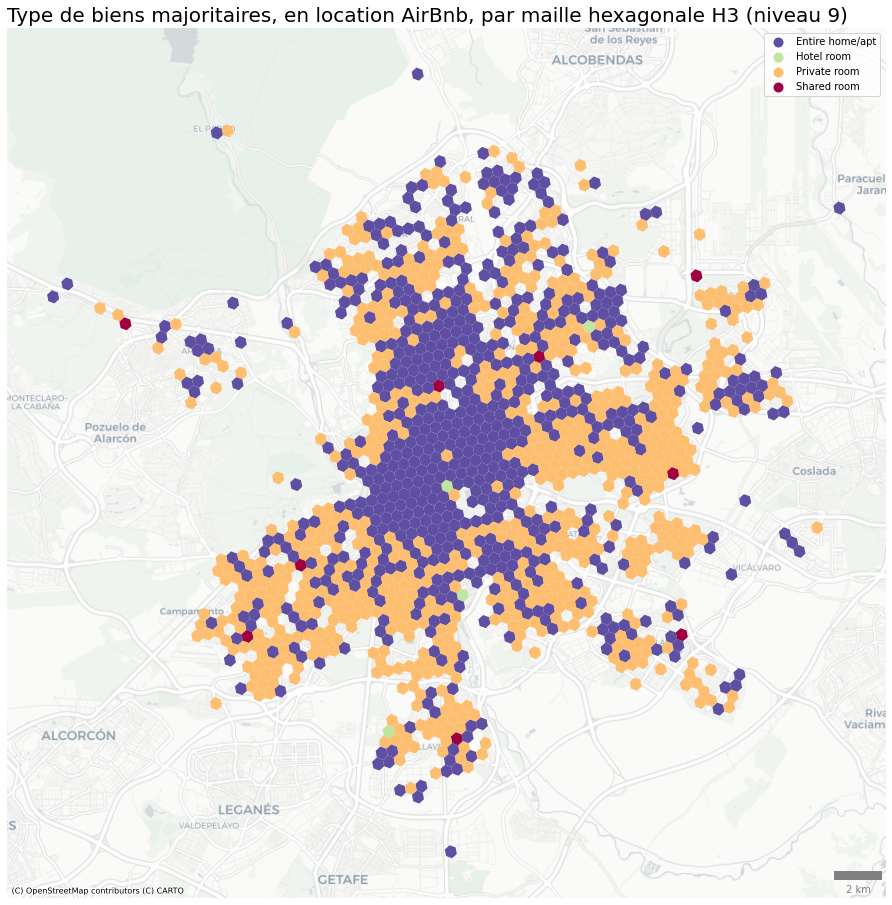

In [ ]:
# Cartographie - Type de biens majoritaires, en location AirBnb, par maille hexagonale H3 (niveau 9)

Carte6, ax = plt.pyplot.subplots(figsize=(18,16)) # Définition de l'interface d'accueil de la carte

# Catégorisation des hexagones en fonction du type de biens le plus présent
Etape10.to_crs('EPSG:3857').plot(ax=ax, column='Type', figsize=(15, 10), cmap='Spectral_r', legend=True)
#Quartiers.boundary.to_crs('EPSG:3857').plot(ax=ax, linewidth=0.2, color = 'black') # Affichage des contours des quartiers

ax.axis("off") # Suppression de l'affichage des objets axes

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron) # Affichage d'un fond de carte

plt.pyplot.title("Type de biens majoritaires, en location AirBnb, par maille hexagonale H3 (niveau 9)", loc='left', fontsize=20) # Affichage d'un titre

# Ajout d'une échelle cartographique
ax.add_artist(ScaleBar(1, length_fraction=0.1, location = "lower right", box_alpha=0, color="grey"))

# plt.pyplot.show() # Affichage de la carte finale

### Analyse du prix moyens des biens en location en fonction du nombre de nuitée minimum catégorisé en fonction de leur type